In [1]:
from utils import *
from dataloader import *
from models import *

import skimage.io as io
import quantities as pq
import numpy as np
import matplotlib.pyplot as plt
from ganrec_dataloader import *
import torch
import os
from torch.utils.data import Dataset
from skimage.transform import resize


In [91]:
def transform(image, transform_type = None, factor = None):
    if transform_type is None:
        transform_type = 'reshape'
    if factor is None:
        factor = 0.5
    if transform_type == 'reshape':
        image = torch_reshape(image)
    elif transform_type == 'normalize':
        image = torchnor_phase(image)
    elif transform_type == 'norm':
        image = torch_norm(image)
    elif transform_type == 'contrast':
        image = torch_reshape(image)
        image = torch_contrast(image, factor)
    elif transform_type == 'contrast_normalize':
        image = torch_reshape(image)
        image = torch_contrast(image, factor)
        image = torchnor_phase(image)
    elif transform_type == 'contrast_norm':
        image = torch_reshape(image)
        image = torch_contrast(image, factor)
        image = torch_norm(image)
    elif transform_type == 'brightness':
        image = torch_reshape(image)
        image = torch_brightness(image, factor)
    elif transform_type == 'brightness_normalize':
        image = torch_reshape(image)
        image = torch_brightness(image, factor)
        image = torchnor_phase(image)
    elif transform_type == 'brightness_norm':
        image = torch_reshape(image)
        image = torch_brightness(image, factor)
        image = torch_norm(image)
    elif transform_type == 'fourier':
        image = torch_reshape(image)
        image = torch.fft.fft2(image)
    elif transform_type =='minmax':
        image = torch_reshape(image)
        image = (image - torch.min(image))/(torch.max(image) - torch.min(image))
    elif transform_type == '-1to1':
        image = torch_reshape(image)
        image = (image - torch.mean(image))/torch.std(image)
        image = (image - torch.min(image))/(torch.max(image) - torch.min(image))
    elif transform_type == 'log':
        image = torch_reshape(image)
        image = torch.log(image)
    else:
        image = torch_reshape(image)
    return image


def get_all_info(path = None, images = None, idx = None, energy_kev = None, detector_pixel_size =None, distance_sample_detector = None, alpha = 1e-8, delta_beta = 1e1, pad = 2, method = 'TIE', file_type = 'tif', image = None, **kwargs):
    """
    make sure that the unit of energy is in keV, the unit of detector_pixel_size is in meter, and the unit of distance_sample_detector is in meter
    """
    if idx is not None and type(idx) is not list:
        idx = [idx]
    
    if images is not None:
        image = [images[i] for i in idx]
    
    if 'image_path' in kwargs.keys():
        image_path = kwargs['image_path']
    else:
        image_path = None

    if 'phase' in kwargs.keys():
        phase = kwargs['phase']
        attenuation = kwargs['attenuation']
    elif 'phase_image' in kwargs.keys():
        phase = kwargs['phase_image']
        attenuation = kwargs['attenuation_image']
    else:
        phase = None
        attenuation = None

    if 'z' in kwargs.keys():
        distance_sample_detector = kwargs['z']
    if 'pv' in kwargs.keys():
        detector_pixel_size = kwargs['pv']
    if 'energy' in kwargs.keys():
        energy_kev = kwargs['energy']

    if 'mode' in kwargs.keys():
        mode = kwargs['mode']
    else:
        mode = 'reflect'
    if 'value' in kwargs.keys():
        value = kwargs['value']
    else:
        value = 'mean'

    

    if type(distance_sample_detector) is list:
        distance_sample_detector = [distance_sample_detector[i] for i in idx] if idx is not None else distance_sample_detector
    if type(detector_pixel_size) is list:
        detector_pixel_size = [detector_pixel_size[i] for i in idx] if idx is not None else detector_pixel_size
        assert len(detector_pixel_size) == len(distance_sample_detector), "detector_pixel_size and distance_sample_detector must have the same length"
    if type(energy_kev) is list:
        energy_kev = [energy_kev[i] for i in idx] if idx is not None else energy_kev
    if type(pad) is list:
        pad = [pad[i] for i in idx] if idx is not None else pad
    lam = wavelength_from_energy(energy_kev).magnitude
    if 'fresnel_number' in kwargs.keys():
        fresnel_number = kwargs['fresnel_number']
    else:
        fresnel_number = [fresnel_calculator(energy_kev, lam, detector_pixel_size, distance) for distance in distance_sample_detector] if type(distance_sample_detector) is list else fresnel_calculator(energy_kev, lam, detector_pixel_size, distance_sample_detector)
    if 'fresnel_factor' in kwargs.keys():
        fresnel_factor = kwargs['fresnel_factor']
    else:
        fresnel_factor = None

    if path is not None:
        #if path is a folder
        if type(path) is str and os.path.isdir(path):
            images = list(io.imread_collection(path + '/*.' + file_type).files)
            image_path = [images[i] for i in idx]
            image = load_images_parallel(image_path)
        elif type(path) is str and os.path.isfile(path):
            
            images = io.imread(path)
            image_path = path
            if len(images.shape) == 2:
                image = images
            elif len(images.shape) == 3:
                image = images[idx,:,:]
            else:
                image = images[idx,:,:,:]
        #if path is a list of files
        elif type(path) is list and not os.path.isfile(path[0]):
            image_path = [path[i] for i in idx]
            image = load_images_parallel(image_path)
        elif type(path) is list and os.path.isdir(path[0]):
            folders = path
            images = []
            for folder in folders:
                images += list(io.imread_collection(folder + '/*.' + file_type).files)
            image_path = [images[i] for i in idx]
            image = load_images_parallel(image_path)
        elif type(path) is np.array:
            image_path = os.getcwd()
            images = path
            image = [images[i] for i in idx]
        else:
            image = [path[i] for i in idx]
            try:
                image = load_images_parallel(image)
            except:
                pass
    else:
        if image is None:
            assert phase is not None and attenuation is not None, "phase and attenuation must be given"
            attenuation = attenuation
            # from ganrec_dataloader import forward_propagate, tensor_to_np
            shape_x, shape_y = phase.shape
            fresnel_factor = ffactors(shape_x*pad, shape_y*pad, energy_kev, distance_sample_detector, detector_pixel_size)
            if type(distance_sample_detector) == list:
                image = [tensor_to_np(forward_propagate(shape_x=shape_x,shape_y=shape_y, pad=pad, energy_kev=energy_kev, detector_pixel_size=detector_pixel_size, distance_sample_detector=distance, phase_image=phase, attenuation_image=attenuation, fresnel_factor=fresnel_factor[i], wavefield=None, distance=distance, mode=mode, value=value)) for i, distance in enumerate(distance_sample_detector)]
            else:    
                image = tensor_to_np(forward_propagate(shape_x=shape_x, shape_y=shape_y, pad=pad, energy_kev=energy_kev, detector_pixel_size=detector_pixel_size, distance_sample_detector=distance_sample_detector, phase_image=phase, attenuation_image=attenuation, fresnel_factor=fresnel_factor, wavefield=None, distance=distance_sample_detector, mode=mode, value=value))
    
    if image is not None: 
        if type(image) is list:
            ND = len(image)
            if len(image[0].shape) == 2:
                shape_x, shape_y = image[0].shape
                Fx, Fy = grid_generator(shape_x, shape_y, upscale=pad, ps = detector_pixel_size)
                ND = 1
                image_path = os.getcwd()
            else:
                shape_x, shape_y = image[0].shape[1:]
                Fx, Fy = grid_generator(shape_x, shape_y, upscale=pad, ps = detector_pixel_size)
        else:
            ND = 1
            shape_x, shape_y = image.shape
            Fx, Fy = grid_generator(shape_x, shape_y, upscale=pad, ps = detector_pixel_size)
        if image_path is None:
            image_path = os.getcwd()
        if images is None:
            images = image

        if 'correct' in kwargs.keys():
            if kwargs['correct'] == True:
                if 'mean_dark_image' and 'mean_ref_image' in kwargs.keys():
                    mean_dark_image = kwargs['mean_dark_image']
                    mean_ref_image = kwargs['mean_ref_image']
                else: 
                    all_images = list(io.imread_collection(path + '/*.' + file_type).files)
                    mean_ref_image = np.mean(io.imread_collection([im_name for im_name in all_images if 'ref' in im_name]), axis = 0)
                    mean_dark_image = np.mean(io.imread_collection([im_name for im_name in all_images if 'dar' in im_name]), axis = 0)
                    
                if len(image) > 1:
                    image = [(image[i] - mean_dark_image) / (mean_ref_image - mean_dark_image) for i in range(len(image))]
                else:
                    image = (image - mean_dark_image) / (mean_ref_image - mean_dark_image)
        if 'downsampling_factor' not in kwargs.keys():
            kwargs['downsampling_factor'] = 1
        else:
            from skimage.transform import resize
            image = [resize(image[i], (image[i].shape[0]//kwargs['downsampling_factor'], image[i].shape[1]//kwargs['downsampling_factor']), anti_aliasing=True) for i in range(len(image))]
            shape_x, shape_y = image[0].shape
            detector_pixel_size = detector_pixel_size * kwargs['downsampling_factor']

        if fresnel_factor is None:
            fresnel_factor = ffactors(shape_x*pad, shape_y*pad, energy_kev, distance_sample_detector, detector_pixel_size)
        

        print(ND, image[0].shape)
        kwargs = {
            "path": path,
            "output_path" : os.getcwd(),
            "idx": idx,
            "column_name": 'path',
            "energy_J": energy_kev_to_joule(energy_kev),
            "energy_kev": energy_kev,
            "lam": lam,
            "detector_pixel_size": detector_pixel_size,
            "distance_sample_detector": distance_sample_detector,
            "fresnel_number": fresnel_number,
            "wave_number": wave_number(energy_kev),
            "downsampling_factor": kwargs['downsampling_factor'],

            "shape_x": shape_x,
            "px": shape_x,
            "shape_y": shape_y,
            "py": shape_y,
            "pad_mode": mode,
            'shape': [int(shape_x), int(shape_y)],
            'distance': [distance_sample_detector],
            'z': distance_sample_detector,
            
            'energy': energy_kev, 
            'alpha': alpha, 
            'pad': pad,
            'nfx': int(shape_x) * pad, 
            'nfy': int(shape_y) * pad,
            'pv': detector_pixel_size,
            'pixel_size': [detector_pixel_size, detector_pixel_size],
            'sample_frequency': [1.0/detector_pixel_size, 1.0/detector_pixel_size],
            'fx': Fx, 'fy': Fy,
            'method': method, 
            'delta_beta': delta_beta,
            "fresnel_factor":  fresnel_factor,
            "i_input": image[0],
            "image_path": image_path,
            "image": image,
            "all_images": images,
            "ND": ND,
            "fresnel_factor": fresnel_factor,
            "phase": phase,
            "attenuation": attenuation,
        } 
        kwargs.update(save_path_generator(**kwargs))
        return kwargs

    else:
        
        assert path is not None
        if type(path) is str:
            assert os.path.exists(path), "path does not exist"
            if os.path.isdir(path):
                images = list(io.imread_collection(path + '/*.' + file_type).files)
                image_path = [images[i] for i in idx]
                image = load_images_parallel(image_path)
            else:
                images = list(path)
                image = load_image(path)
            get_all_info(image=image, **kwargs)
        elif type(path) is list:
            path = [path[i] for i in idx]
            if type(path[0]) is str:
                #if the path[0] is a folder
                if os.path.isdir(path[0]):
                    images = list(io.imread_collection(path + '/*.' + file_type).files)
                    image_path = [images[i] for i in idx]
                else:
                    image_path = path
                image = load_images_parallel(image_path)
            else:
                image = [path[i] for i in idx]
            get_all_info(image=image, **kwargs)
        else:
            images = path
            image = [images[i] for i in idx]
            get_all_info(image=image, **kwargs)

def get_setup_info(dict = {}):
    #rearrange them in a descending order based on length
    dict = {k: v for k, v in sorted(dict.items(), key=lambda item: len(item[0]) + len(str(item[1])), reverse=True)}
    len_line = 0
    for key, value in dict.items():
        if type(value) == str or  type(value) == int or type(value) == float or type(value) == bool: 
            if len(key) > len_line:
                len_line = len(key)
        elif type(value) == np.ndarray:
            if len(value.shape) == 0:
                if len(key) > len_line:
                    len_line = len(key)
        else: 
            try:
                from ganrec_dataloader import tensor_to_np
                if type(tensor_to_np(value)) == np.ndarray and len(tensor_to_np(value).shape) == 0:
                    if len(key) > len_line:
                        len_line = len(key)
            except:
                pass
    len_line += 10
    line = '_'*len_line 
    information = line + '\n'
    for key, value in dict.items():
        if type(value) == str or type(value) == int or type(value) == float or type(value) == bool:
            information += '| ' +key +': '+ str(value) +' \n'
        elif type(value) == np.ndarray and len(value.shape) == 0:
            information += '| ' +key +': '+ str(value) +' \n'
        else:
            try:
                from ganrec_dataloader import tensor_to_np
                if type(tensor_to_np(value)) == np.ndarray and len(tensor_to_np(value).shape) == 0:
                    information += '| ' +key +': '+ str(tensor_to_np(value)) +' \n'
            except:
                pass
    information += line + ' \n'
    print(information)
    return information, len_line

def get_file_nem(dict):
    name = ''
    important_keys = ['experiment_name', 'abs_ratio', 'iter_num', 'downsampling_factor', 'l1_ratio', 'contrast_ratio', 'normalized_ratio', 'brightness_ratio', 'contrast_normalize_ratio', 'brightness_normalize_ratio', 'l2_ratio', 'fourier_ratio']
    for key in important_keys:
        if key in dict.keys():
            name += key + '_' + str(dict[key]) + '__'
    return name

def time_to_string(time):
    if time > 60:
        if time > 3600:
            if time > 3600*24:
                return str(int(time//(3600*24))) + ' days ' + str(int((time%(3600*24))//3600)) + ' hours ' + str(int((time%3600)//60)) + ' minutes ' + str(int(time%60)) + ' seconds'
            else:
                return str(int(time//3600)) + ' hours ' + str(int((time%3600)//60)) + ' minutes ' + str(int(time%60)) + ' seconds'
        else:
            return str(int(time//60)) + ' minutes ' + str(int(time%60)) + ' seconds'
    else:
        return str(int(time%60)) + ' seconds'

class Ganrec_Dataloader(Dataset):
    """
    The dataloader takes the different arguements and arranges it in a way that it can be used for the training and other purposes.
    ********************************
    Transform_type can be: 'reshape', 'normalize', 'contrast', 'contrast_normalize', 'brightness', 'norm'
    The image is then saved in the transformed_images variable. This will be used for the training.

    If there are multiple images, the idx variable is used to choose the image. 
    Batch_size is the number of images in the batch, which can be used for the training. 
    The batch_images variable is used to get the batch of images. The idx_batches variable is used to get the
    
    get_all_info() is used to get the information about the image and the fresnel factor.

    If phase and attenuation are provided, the forward propagation is done and saved in the propagated_forward variable.
    The fresnel factor is also saved in the fresnel_factor variable.
    ********************************
    """
    def __init__(self,**kwargs):
        self.kwargs = get_args()
        self.kwargs.update(kwargs)
        
        if 'downsampling_factor' not in self.kwargs.keys():
            self.kwargs['downsampling_factor'] = 1
        else:
            from skimage.transform import resize
            
        self.kwargs.update(get_all_info(**kwargs))
        if 'phase' not in self.kwargs.keys() and 'attenuation' not in self.kwargs.keys():
            kwargs['phase'] = None
            kwargs['attenuation'] = None
        keys = self.kwargs.keys()
        [self.__setattr__(key, self.kwargs[key]) for key in keys]
        self.dims = (self.ND, self.shape_x, self.shape_y)
        self.transformed_images = transform(self.image, self.kwargs['transform_type'], self.kwargs['transform_factor'])
        self.kwargs['transform_type'] = self.transform_type
        self.kwargs['transform_factor'] = self.transform_factor
        self.kwargs['transformed_images'] = self.transformed_images
        self.batch_size = self.transformed_images.shape[0]
        super(Ganrec_Dataloader, self).__init__()
        if 'mode' in self.kwargs.keys():
            self.mode = self.kwargs['mode']
        else:
            self.mode = 'reflect'
        if 'value' in self.kwargs.keys():
            self.value = self.kwargs['value']

    def __len__(self):
        return len(self.image_path)
    
    def __getitem__(self, idx = None, transform_type = None): 
            
        if idx is not None:
            kwargs = self.kwargs
            if transform_type is not None:
                kwargs['transform_type'] = transform_type
            kwargs["idx"] = idx
            new = Ganrec_Dataloader(**kwargs)
            return new.transformed_images
        else:
            return self.transformed_images
    
    def __getbatchimages__(self, batch_size = None, transform_type = None):
        """
        Returns a batch of transformed images:
        ********************************
        batch_images, idx_batches = dataloader.__getbatchimages__(batch_size = 100, transform_type = 'reshape')
        for i, image in enumerate(batch_images):
            print(image.shape)
        ********************************
        """
        if batch_size is None:
            batch_size = self.batch_size
        if transform_type is None:
            transform_type = self.kwargs['transform_type']
        all_images = self.all_images
        n = len(all_images)
        seed = self.seed
        import random
        random.seed(seed)
        all_idx = list(range(n))
        random.shuffle(all_idx)
        idx_batches = [all_idx[i:i + batch_size] for i in range(0, n, batch_size)]
        batch_images = []
        from joblib import Parallel, delayed
        n_jobs = max(30, len(idx_batches))
        batch_images = Parallel(n_jobs=n_jobs)(delayed(self.__getitem__)(idx, transform_type) for idx in idx_batches)
        return batch_images, idx_batches
    
    def update_values(self, change_all = False, **info):
        """
        This function is used to update the values of the dataloader. 
        If the change is a shouldn't affect values from the get_all_info() function, then change_all should be False.
        Otherwise, it should be True.
        """

        if change_all:
            kwargs = self.kwargs
            kwargs.update(info)
            kwargs.update(get_all_info(**kwargs))
            [self.__setattr__(key, kwargs[key]) for key in kwargs.keys()]
            self.transformed_images = transform(self.image, kwargs['transform_type'], kwargs['transform_factor'])
            self.dims = (self.ND, self.shape_x, self.shape_y)
            print(self.kwargs['transform_type'])
        else:
            kwargs = self.kwargs
            kwargs.update(info)
            [self.__setattr__(key, info[key]) for key in info.keys()]
            # if 'transform_type' in info.keys() or 'transform_factor' in info.keys():
            #     self.transformed_images = transform(self.image, self.kwargs['transform_type'], self.kwargs['transform_factor'])
            #     self.dims = (self.ND, self.shape_x, self.shape_y)
            #     print(self.kwargs['transform_type'])
        
        return self
            
    def normalize(self, idx = None, transform_type = None):
        image = self.__getitem__(idx, transform_type)
        # image = torchnor_phase(image)
        return image
    
    def get_kwargs(self):
        return self.__dict__
    
    def visualize(self, idx = None, show_or_plot = 'show', tranformed = False):
        if idx is not None:
            kwargs = self.kwargs
            kwargs["idx"] = idx
            new = Ganrec_Dataloader(**kwargs)
        else:
            new = self
        if tranformed:
            images = new.transformed_images
            try:
                images = images[:,0,:,:].detach().cpu().numpy()
            except:
                images = images[0,:,:].numpy()
        else:
            images = new.image

        if type(images) is not list:
            # images = [images]
            images = list(images)
        fig = visualize(images, show_or_plot = show_or_plot)
        return fig
    
    def forward_propagate(self, distance = None):
        distance = self.distance_sample_detector if distance is None else distance
        wavefield = None if 'wavefield' not in self.kwargs.keys() else self.kwargs['wavefield']

        if type(distance) is not list:
            self.propagated_forward = forward_propagate(shape_x = self.shape_x, shape_y = self.shape_y, pad = self.pad, energy_kev = self.energy_kev, detector_pixel_size = self.detector_pixel_size, distance_sample_detector = distance, phase_image = self.phase, attenuation_image = self.attenuation, fresnel_factor  = self.fresnel_factor, wavefield = wavefield, distance = distance, mode = self.mode, value = self.value)
        else:
            propagated_forward = [forward_propagate(shape_x = self.shape_x, shape_y = self.shape_y, pad = self.pad, energy_kev = self.energy_kev, detector_pixel_size = self.detector_pixel_size, distance_sample_detector = distance[i], phase_image = self.phase, attenuation_image = self.attenuation, fresnel_factor  = None, wavefield = wavefield, distance = distance[i], mode=self.mode, value=self.value) for i in range(len(distance))]
            self.propagated_forward = torch.stack(propagated_forward, dim = 0)[:,0,:,:,:]
            print(self.propagated_forward.shape)
        return self.propagated_forward

class make_ganrec_model(nn.Module):
    def __init__(self, shape_x, shape_y, conv_num, conv_size, dropout, output_num, fresnel_factor, transformed_images=None, device=None, **kwargs):
        super(make_ganrec_model, self).__init__()
        for key, value in kwargs.items():
            setattr(self, key, value)
        self.device = device
        if self.device is None:
            self.device = torch.device("cuda:4" if torch.cuda.is_available() else "cpu")
        
        self.fresnel_factor = to_device(torch_reshape(fresnel_factor, complex=True), self.device)
        self.transformed_images = to_device(transformed_images, self.device)
        self.image = to_device(self.image, self.device)
        self.shape_x = shape_x
        self.shape_y = shape_y
        self.conv_num = conv_num
        self.conv_size = conv_size
        self.dropout = dropout
        self.output_num = output_num
        self.units = 128
        self.fc_size = shape_x * shape_y
        
        self.possible_distance_gap = None if 'possible_distance_gap' not in kwargs.keys() or kwargs['possible_distance_gap'] == 0 else kwargs['possible_distance_gap']
        self.number_of_distances = None if 'number_of_distances' not in kwargs.keys() else kwargs['number_of_distances']
        self.possible_distances = list(np.linspace(self.distance_sample_detector - self.possible_distance_gap*self.number_of_distances, self.distance_sample_detector + self.possible_distance_gap*self.number_of_distances, self.number_of_distances+1)) if self.possible_distance_gap is not None else [self.distance_sample_detector]
        self.possible_fresnels_factors = torch_reshape([ffactors(self.shape_x, self.shape_y, self.energy_kev, distance, self.detector_pixel_size) for distance in self.possible_distances], complex = True)

        if 'mode' in kwargs.keys():
            self.mode = kwargs['mode']
        else:
            self.mode = 'constant'
        if 'value' in kwargs.keys():
            self.value = kwargs['value']
        else:
            self.value = 'mean'
        if 'abs_ratio' in kwargs.keys():
            self.abs_ratio = kwargs['abs_ratio']
        else:
            self.abs_ratio = 1
        ##################################################################################################
        # We first define the generator model
        ##################################################################################################
        
        self.fc_stack = nn.ModuleList([
            dense_layer(in_features=self.units, out_features=self.units, dropout=self.dropout),
            dense_layer(in_features=self.units, out_features=self.units, dropout=self.dropout),
            dense_layer(in_features=self.units, out_features=self.units, dropout=self.dropout),
            # dense_layer(in_features=self.units, out_features=self.units, dropout=self.dropout),
        ])
        self.conv_stack = nn.ModuleList([
            conv2d_layer(in_channels=1, out_channels=self.conv_num, kernel_size=self.conv_size+2, stride=1),
            conv2d_layer(in_channels=self.conv_num, out_channels=self.conv_num, kernel_size=self.conv_size+2, stride=1),
            # conv2d_layer(in_channels=self.conv_num, out_channels=self.conv_num, kernel_size=self.conv_size+2, stride=1),
            conv2d_layer(in_channels=self.conv_num, out_channels=self.conv_num, kernel_size=self.conv_size, stride=1),
        ])
        self.dconv_stack = nn.ModuleList([
            deconv2d_layer(in_channels=self.conv_num, out_channels=self.conv_num, kernel_size=self.conv_size+2, stride=1),
            # deconv2d_layer(in_channels=self.conv_num, out_channels=self.conv_num, kernel_size=self.conv_size+2, stride=1),
            deconv2d_layer(in_channels=self.conv_num, out_channels=self.conv_num, kernel_size=self.conv_size+2, stride=1),
            deconv2d_layer(in_channels=self.conv_num, out_channels=self.output_num, kernel_size=self.conv_size+2, stride=1),
            
        ])
        self.last = conv2d_layer(in_channels=self.output_num, out_channels=self.output_num, kernel_size=self.conv_size, stride=1)
        
        self.generator_model = to_device(nn.Sequential(
            nn.Flatten(),
            Transpose(),
            dense_layer(in_features=1, out_features=self.units, dropout=self.dropout, transpose=False),
            *self.fc_stack,
            dense_layer(in_features=self.units, out_features=1, dropout=0),
            Reshape((-1, 1, self.shape_x, self.shape_y)),
            *self.conv_stack,
            *self.dconv_stack,
            self.last,
        ), self.device)

        if 'init_model' in kwargs.keys():
            if kwargs['init_model']:
                # Load the model
                init_model_path = kwargs.get('init_model_path', 'model/ganrec_model')
                self.generator_model.load_state_dict(torch.load(init_model_path))

        else:
            self.init_weights()

        ##################################################################################################
        # We then define the discriminator model
        ##################################################################################################

        discriminator_stack = nn.ModuleList([
            conv2d_layer(in_channels=1, out_channels=16, kernel_size=5, stride=2),
            conv2d_layer(in_channels=16, out_channels=16, kernel_size=5, stride=1),
            conv2d_layer(in_channels=16, out_channels=32, kernel_size=5, stride=2),
            conv2d_layer(in_channels=32, out_channels=32, kernel_size=5, stride=1),
            conv2d_layer(in_channels=32, out_channels=64, kernel_size=3, stride=2),
            conv2d_layer(in_channels=64, out_channels=64, kernel_size=3, stride=1),
            conv2d_layer(in_channels=64, out_channels=64, kernel_size=3, stride=2),
            conv2d_layer(in_channels=64, out_channels=64, kernel_size=3, stride=1),
            nn.Flatten(),
        ])

        self.discriminator_model =  to_device(nn.Sequential(
            *discriminator_stack
        ), self.device)

        self.reshaped = to_device(transform(self.image, 'reshape') , self.device)
        self.normalized = transform(self.reshaped, 'normalize')
        self.norm = transform(self.reshaped, 'norm')
        self.contrast = transform(self.reshaped, 'contrast', self.transform_factor)
        self.contrast_normalize = transform(self.reshaped, 'constrast_normalize', self.transform_factor)
        self.brightness = transform(self.reshaped, 'brightness', self.transform_factor)
        self.brightness_normalize = transform(self.reshaped, 'brightness_normalize', self.transform_factor)
        self.fourier = torch.fft.fft2(self.reshaped)

    def init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
                init.xavier_uniform_(m.weight)
                if m.bias is not None:
                    init.zeros_(m.bias)

    def make_model(self):
        self.generator = self.generator_model
        self.discriminator = self.discriminator_model
        self.generator_optimizer = torch.optim.Adam(self.generator.parameters(), lr=1e-3)
        self.discriminator_optimizer = torch.optim.Adam(self.discriminator.parameters(), lr=1e-5)
        
    def forward_generator(self, x):
        self.pred = self.generator_model(x)
        return self.pred

    def forward_discriminator(self, x):
        self.likelihood = self.discriminator_model(x)
        return self.likelihood
    
    def transform(self, x):
        if 'transform_type' in self.kwargs.keys():
            transform_type = self.kwargs['transform_type']
        else:
            transform_type = 'normalize'

        if 'transform_factor' in self.kwargs.keys():
            transform_factor = self.kwargs['transform_factor']
        else:
            transform_factor = 0.5
        return transform(x, transform_type, transform_factor)
    
    def propagate_and_difference(self, distance, index):
        fresnel_factor = to_device(self.possible_fresnels_factors[index, 0], self.device)
        propagated_intensity = forward_propagate(shape_x = self.shape_x, shape_y = self.shape_y, pad = self.pad, energy_kev = self.energy_kev, detector_pixel_size = self.detector_pixel_size, distance_sample_detector = distance, phase_image = self.phase, attenuation_image = self.attenuation, fresnel_factor  = fresnel_factor, wavefield = None, distance =  distance, mode = self.mode, value = self.value)
        difference = propagated_intensity - self.transformed_images
        main_diff = torch.mean(torch.abs(difference))
        return main_diff

    def find_best_distance(self, possible_distances):
        results = torch.zeros(len(possible_distances))
        for i, distance in enumerate(possible_distances):
            results[i] = self.propagate_and_difference(distance, i)
        if torch.min(results) < self.main_diff:
            self.distance_sample_detector = possible_distances[torch.argmin(results)]
            self.fresnel_factor = to_device(self.possible_fresnels_factors[torch.argmin(results)], self.device)
            print("The distance is updated to: ", self.distance_sample_detector)
            print("old difference: ", self.main_diff, " and new difference: ", torch.min(results))
    
    def propagator(self):
        phase = transform(self.pred[:,0,:,:], 'normalize') #*2 -1) * torch.pi
        attenuation =  (1 - transform(self.pred[:,1,:,:], 'normalize'))*self.abs_ratio
        propagated_intensity = transform(forward_propagate(shape_x = self.shape_x, shape_y = self.shape_y, pad = self.pad, energy_kev = self.energy_kev, detector_pixel_size = self.detector_pixel_size, distance_sample_detector = self.distance_sample_detector, phase_image = phase, attenuation_image = attenuation, fresnel_factor  = self.fresnel_factor, wavefield = None, distance =  self.distance_sample_detector, mode = self.mode, value = self.value), self.transform_type, self.transform_factor)
        self.difference = propagated_intensity - self.transformed_images
        self.main_diff = torch.mean(torch.abs(self.difference))

        if self.possible_distance_gap is not None and self.epoch == 1:
            self.find_best_distance(self.possible_distances)

        if self.possible_distance_gap is not None and self.epoch > 1:
            if np.mean(self.main_diff_list[-10:]) < 0.001:
                self.find_best_distance(self.possible_distances)
        
        return propagated_intensity, phase, attenuation
    
    def forward(self, x = None):
        x = self.transformed_images if x is None else x
        self.pred = self.generator(x)
        propagated_intensity, phase, attenuation = self.propagator()
        self.fake_output = self.discriminator(propagated_intensity)
        self.real_output = self.discriminator(x)
        return self.fake_output, self.real_output, propagated_intensity, phase, attenuation
    
    def generator_loss(self, fake_output, x, propagated_intensity, l1_ratio = 10, contrast_ratio = 0, normalized_ratio = 0, brightness_ratio = 0, contrast_normalize_ratio = 10, brightness_normalize_ratio = 0, l2_ratio = 0, fourier_ratio = 0):
        x = self.transformed_images if x is None else x
        if self.epoch > self.iter_num//10 + 1:
            contrast_ratio = 0
            contrast_normalize_ratio = 0
            brightness_ratio = 0
            brightness_normalize_ratio = 0
        if self.epoch < self.iter_num//90:
            fourier_ratio = 0

        cross_entropy = torch.mean(torch.nn.BCEWithLogitsLoss()(fake_output, torch.ones_like(fake_output)))
        l2_loss = torch.mean(torch.square(self.difference)) if l2_ratio != 0 else 0

        contrast_diff = torch.mean(torch.abs(self.contrast - transform(propagated_intensity, 'contrast', self.transform_factor))) if contrast_ratio != 0 else 0
        contrast_noramlize_difference = torch.mean(torch.square(self.contrast_normalize - transform(propagated_intensity, 'contrast_normalize', self.transform_factor))) if contrast_normalize_ratio != 0 else 0
        brightness_noramlize_difference = torch.mean(torch.square(self.brightness_normalize - transform(propagated_intensity, 'brightness_normalize', 1 - self.transform_factor))) if brightness_normalize_ratio != 0 else 0
        brightness_diff = torch.mean(torch.square(self.brightness - transform(propagated_intensity, 'brightness', 1 - self.transform_factor))) if brightness_ratio != 0 else 0
        
        norm_diff = torch.mean(torch.abs(self.norm - transform(propagated_intensity, 'norm', self.transform_factor))) if normalized_ratio != 0 else 0
        normalized_diff = torch.mean(torch.abs(self.normalized - transform(propagated_intensity, 'normalize', self.transform_factor))) if normalized_ratio != 0 else 0
        
        #use logaritmic loss for the fourier difference
        fourier_diff_real = torch.mean(torch.square(torch.log(torch.abs(torch.fft.fft2(propagated_intensity).real + 1)) - torch.log(torch.abs(self.fourier.real) + 1))) if fourier_ratio != 0 else 0
        fourier_diff_imag = torch.mean(torch.square(torch.log(torch.abs(torch.fft.fft2(propagated_intensity).imag + 1)) - torch.log(torch.abs(self.fourier.imag) + 1))) if fourier_ratio != 0 else 0
        fourier_diff = fourier_diff_real + fourier_diff_imag
        return cross_entropy + l1_ratio * self.main_diff + contrast_ratio * contrast_diff + normalized_ratio * norm_diff + normalized_ratio * normalized_diff + brightness_ratio * brightness_diff + contrast_normalize_ratio * contrast_noramlize_difference + brightness_normalize_ratio * brightness_noramlize_difference + l2_ratio * l2_loss + fourier_ratio * fourier_diff

    def discriminator_loss(self, real_output, fake_output):
        real_loss = torch.mean(torch.nn.BCEWithLogitsLoss()(real_output, torch.ones_like(real_output)))
        fake_loss = torch.mean(torch.nn.BCEWithLogitsLoss()(fake_output, torch.zeros_like(fake_output)))
        total_loss = real_loss + fake_loss
        return total_loss
    
    def train_step(self, x, l1_ratio = 10, contrast_ratio = 0, normalized_ratio = 0, brightness_ratio = 0, contrast_normalize_ratio = 0, brightness_normalize_ratio = 0, l2_ratio = 0, fourier_ratio = 0):
        self.generator_optimizer.zero_grad()
        self.discriminator_optimizer.zero_grad()
        self.fake_output, self.real_output, self.propagated_intensity, self.phase, self.attenuation = self.forward(x)
        self.gen_loss = self.generator_loss(self.fake_output, x, self.propagated_intensity, l1_ratio = l1_ratio, l2_ratio = l2_ratio, contrast_ratio = contrast_ratio, normalized_ratio = normalized_ratio, brightness_ratio = brightness_ratio, contrast_normalize_ratio = contrast_normalize_ratio, brightness_normalize_ratio = brightness_normalize_ratio)
        self.dis_loss = self.discriminator_loss(self.real_output, self.fake_output)
        self.gen_loss.backward(retain_graph=True)
        self.dis_loss.backward()
        self.generator_optimizer.step()
        self.discriminator_optimizer.step()
        return self.gen_loss, self.dis_loss, self.propagated_intensity, self.phase, self.attenuation
    
    def train(self, iter_num = None, save_model = None, save_model_path = None, l1_ratio = 10, contrast_ratio = 0, normalized_ratio = 0, brightness_ratio = 0, contrast_normalize_ratio = 0, brightness_normalize_ratio = 0, l2_ratio = 0, fourier_ratio = 0):
        
        iter_num = self.iter_num if iter_num is None else iter_num
        save_model = self.save_model if save_model is None else save_model
        save_model_path = self.save_model_path if save_model_path is None else save_model_path
        self.make_model()
        self.gen_loss_list = []
        self.dis_loss_list = []
        self.propagated_intensity_list = []
        self.phase_list = []
        self.attenuation_list = []
        self.main_diff_list = []
        self.epoch_time = []

        import time
        self.start_time = time.time()  
        for i in range(iter_num):
            self.epoch = i
            self.g_loss, self.d_loss, self.propagated_intensity, self.phase, self.attenuation = self.train_step(None, l1_ratio = l1_ratio, contrast_ratio = contrast_ratio, normalized_ratio = normalized_ratio, brightness_ratio = brightness_ratio, contrast_normalize_ratio = contrast_normalize_ratio, brightness_normalize_ratio = brightness_normalize_ratio, l2_ratio = l2_ratio, fourier_ratio = fourier_ratio)
            self.gen_loss_list.append(tensor_to_np(self.gen_loss))
            self.dis_loss_list.append(tensor_to_np(self.dis_loss))
            self.main_diff_list.append(tensor_to_np(self.main_diff))
            self.propagated_intensity_list.append(tensor_to_np(self.propagated_intensity))
            self.phase_list.append(tensor_to_np(self.phase))
            self.attenuation_list.append(tensor_to_np(self.attenuation))
            self.epoch_time.append(time.time() - self.start_time)
            if i % 100 == 0:
                print('gen_loss: ', self.g_loss, 'dis_loss: ', self.d_loss, 'main_diff: ', self.main_diff, "t_epoch: ", self.epoch_time[-1], "remaining time: ", time_to_string(self.epoch_time[0] * iter_num - self.epoch_time[0] * i))
            
            # if self.epoch > self.iter_num//90 and torch.abs(self.main_diff - np.mean(self.main_diff_list[-100:])) < 0.00001:
            #     for param_group in self.generator_optimizer.param_groups:
            #         param_group['lr'] = param_group['lr'] * 0.9
            #     for param_group in self.discriminator_optimizer.param_groups:
            #         param_group['lr'] = param_group['lr'] * 0.9  
            # if self.epoch > self.iter_num//90 and torch.abs(self.main_diff - np.mean(self.main_diff_list[-100:])) < 0.000001:
            #     print('Training stopped')
            #     self.iter_num = self.epoch
            #     self.main_diff_list.append(tensor_to_np(self.main_diff))    
            #     break
        if save_model is True and save_model_path is not None:
            torch.save(self.generator.state_dict(), save_model_path)
        self.total_time = time.time() - self.start_time
        return self.gen_loss_list, self.dis_loss_list, self.propagated_intensity_list, self.phase_list, self.attenuation_list
    
    def test(self, iter_num, testloader, save_model = False, save_model_path = None):
        from torch.autograd import Variable
        self.generator.to(self.device)
        self.discriminator.to(self.device)
        self.generator.eval()
        self.discriminator.eval()
        self.gen_loss_list = []
        self.dis_loss_list = []
        self.propagated_intensity_list = []
        self.phase_list = []
        self.attenuation_list = []
        for i in range(iter_num):
            self.epoch = i
            self.gen_loss, self.dis_loss, self.propagated_intensity, self.phase, self.attenuation = self.train_step(testloader)
            self.gen_loss_list.append(tensor_to_np(self.gen_loss))
            self.dis_loss_list.append(tensor_to_np(self.dis_loss))
            self.propagated_intensity_list.append(tensor_to_np(self.propagated_intensity))
            self.phase_list.append(tensor_to_np(self.phase))
            self.attenuation_list.append(tensor_to_np(self.attenuation))
            if i % 10 == 0:
                print('gen_loss: ', self.gen_loss, 'dis_loss: ', self.dis_loss, 'main_diff: ', self.main_diff)
        if save_model:
            torch.save(self.generator.state_dict(), save_model_path)
        return self.gen_loss_list, self.dis_loss_list, self.propagated_intensity_list, self.phase_list, self.attenuation_list

    def live_plot(self, iter_num = None, rate = 1):
        import matplotlib.pyplot as plt
        from IPython.display import clear_output
        if iter_num is None:
            iter_num = self.iter_num
        for i in range(iter_num):
            clear_output(wait=True) 
            if i % rate == 0:       
                plt.figure(figsize=(20,10))                            
                plt.subplot(1,3,3)
                plt.subplot(1,3,3)
                plt.plot(self.gen_loss_list, label='gen_loss')
                plt.plot(self.dis_loss_list, label='dis_loss')
                plt.plot(self.main_diff_list, label='main_diff')
                plt.title('iteration: '+str(i))
                plt.legend()
                plt.subplot(1,3,1)
                plt.title('propagated_intensity')
                plt.imshow(self.propagated_intensity_list[i][-1], cmap='gray')
                plt.colorbar()
                plt.subplot(1,3,2)
                plt.title('phase')
                plt.imshow(self.phase_list[i], cmap='coolwarm')
                plt.colorbar()
                plt.gca()
            plt.show()

    def save(self, path = None, name = None):
        if path is None:
            path = self.save_path
        if name is None:
            name = get_file_nem(self.__dict__)
        if not os.path.exists(path):
            os.makedirs(path)
        if not os.path.exists(path + 'propagated/'):
            os.makedirs(path + 'propagated/')
        if not os.path.exists(path + 'phase/'):
            os.makedirs(path + 'phase/')
        if not os.path.exists(path + 'abs/'):
            os.makedirs(path + 'abs/')
        if path[-1] != '/':
            path += '/'
            
        torch.save(self.generator.state_dict(), path + 'generator_'+name+'.pth')
        torch.save(self.discriminator.state_dict(), path + 'discriminator_' + name + '.pth')
        np.save(path + 'gen_loss_' + name + '.npy', self.gen_loss_list)
        np.save(path + 'dis_loss_' + name + '.npy', self.dis_loss_list)
        io.imsave(path + 'propagated/propagated_intensity_' + name + '.npy', self.propagated_intensity_list[-1])
        io.imsave.save(path + 'phase/phase_' + name + '.npy', self.phase_list[-1])
        io.imsave(path + 'abs/attenuation_' + name + '.npy', self.attenuation_list[-1])

        return path + name


In [3]:

path = '/asap3/petra3/gpfs/p05/2023/data/11017690/processed/nano111233_sf04_1p2p1_OV_JD/logs/nano111233_sf04_1p2p1_OV_reco_single/2023-11-03_17-32-56_flatfield_corrected.tiff'
images = io.imread_collection(os.path.dirname(path) + '/*.tiff')


orig_image = io.imread(path)
downsampling_factor = 4
image = resize(orig_image, (orig_image.shape[0]//downsampling_factor, orig_image.shape[1]//downsampling_factor), anti_aliasing=True)
energy = 11.0 * pq.keV
lam = wavelength_from_energy(energy)
fresnel_number = 0.03676752780701798 * pq.dimensionless
pv = pq.Quantity(6500.0 * pq.nanometer, 'm')

z01 =  pq.Quantity(2154255556* pq.nanometer, 'm')
z02 =  pq.Quantity(19860915713.140064 * pq.nanometer, 'm')
z12 = z02 - z01
M = (z01 + z12)/z01

zeff = pq.Quantity(z12/M, 'm')
pv2 = pv*downsampling_factor/M
z = pv2**2 / (lam * fresnel_number)
new_fresnel_number = pv2**2 / (lam * zeff)
# print(z, pq.Quantity(z01, 'm'), pq.Quantity(z12, 'm'), M, pq.Quantity(zeff, 'm'), fresnel_number, pv**2 / (lam * zeff))
print("shape", image.shape, " z from fresnel", z , "\n", "z01", z01, "\n", "z12", z12, "\n", "M", M, "\n", "zeff", zeff, "\n", "fresnel_number", fresnel_number, "\n", "pv2", pv2, "\n", "new_fresnel_number", new_fresnel_number)
# for i, image in enumerate(images.files):
#     if 'flatfield_corrected' in image:
#         print(i, image)

# for i, image in enumerate(images.files):
    # if 'intensities' in image:
    #     print(i, image)
z = zeff

shape (512, 512)  z from fresnel 1.9191507469051687 m 
 z01 2.1542555560000003 m 
 z12 17.706660157140067 m 
 M 9.219387021109794 dimensionless 
 zeff 1.9205897438296942 m 
 fresnel_number 0.03676752780701798 dimensionless 
 pv2 2.820144109415012e-06 m 
 new_fresnel_number 0.0367399798313992 dimensionless


In [4]:
# 201 /asap3/petra3/gpfs/p05/2023/data/11017690/processed/nano111233_sf04_1p2p1_OV_JD/logs/nano111233_sf04_1p2p1_OV_reco_single/2023-11-03_16-54-22_flatfield_corrected.tiff
# 234 /asap3/petra3/gpfs/p05/2023/data/11017690/processed/nano111233_sf04_1p2p1_OV_JD/logs/nano111233_sf04_1p2p1_OV_reco_single/2023-11-03_16-56-30_flatfield_corrected.tiff
# 275 /asap3/petra3/gpfs/p05/2023/data/11017690/processed/nano111233_sf04_1p2p1_OV_JD/logs/nano111233_sf04_1p2p1_OV_reco_single/2023-11-03_16-58-29_flatfield_corrected.tiff
# 326 /asap3/petra3/gpfs/p05/2023/data/11017690/processed/nano111233_sf04_1p2p1_OV_JD/logs/nano111233_sf04_1p2p1_OV_reco_single/2023-11-03_17-07-07_flatfield_corrected.tiff
# 355 /asap3/petra3/gpfs/p05/2023/data/11017690/processed/nano111233_sf04_1p2p1_OV_JD/logs/nano111233_sf04_1p2p1_OV_reco_single/2023-11-03_17-07-42_flatfield_corrected.tiff
# 388 /asap3/petra3/gpfs/p05/2023/data/11017690/processed/nano111233_sf04_1p2p1_OV_JD/logs/nano111233_sf04_1p2p1_OV_reco_single/2023-11-03_17-08-37_flatfield_corrected.tiff
# 431 /asap3/petra3/gpfs/p05/2023/data/11017690/processed/nano111233_sf04_1p2p1_OV_JD/logs/nano111233_sf04_1p2p1_OV_reco_single/2023-11-03_17-09-27_flatfield_corrected.tiff
# 482 /asap3/petra3/gpfs/p05/2023/data/11017690/processed/nano111233_sf04_1p2p1_OV_JD/logs/nano111233_sf04_1p2p1_OV_reco_single/2023-11-03_17-11-19_flatfield_corrected.tiff
# 533 /asap3/petra3/gpfs/p05/2023/data/11017690/processed/nano111233_sf04_1p2p1_OV_JD/logs/nano111233_sf04_1p2p1_OV_reco_single/2023-11-03_17-18-20_flatfield_corrected.tiff
# 584 /asap3/petra3/gpfs/p05/2023/data/11017690/processed/nano111233_sf04_1p2p1_OV_JD/logs/nano111233_sf04_1p2p1_OV_reco_single/2023-11-03_17-28-08_flatfield_corrected.tiff
# 635 /asap3/petra3/gpfs/p05/2023/data/11017690/processed/nano111233_sf04_1p2p1_OV_JD/logs/nano111233_sf04_1p2p1_OV_reco_single/2023-11-03_17-31-47_flatfield_corrected.tiff
# 680 /asap3/petra3/gpfs/p05/2023/data/11017690/processed/nano111233_sf04_1p2p1_OV_JD/logs/nano111233_sf04_1p2p1_OV_reco_single/2023-11-03_17-32-56_flatfield_corrected.tiff
# 725 /asap3/petra3/gpfs/p05/2023/data/11017690/processed/nano111233_sf04_1p2p1_OV_JD/logs/nano111233_sf04_1p2p1_OV_reco_single/2023-11-03_17-33-38_flatfield_corrected.tiff
# 776 /asap3/petra3/gpfs/p05/2023/data/11017690/processed/nano111233_sf04_1p2p1_OV_JD/logs/nano111233_sf04_1p2p1_OV_reco_single/2023-11-03_17-52-42_flatfield_corrected.tiff
info = {
    'path': images,
    'downsampling_factor': downsampling_factor,
    'energy_kev': energy.magnitude,
    'pv': pv.magnitude,
    'z': z.magnitude,
    'fresnel_number': fresnel_number.magnitude,
    'lam': lam.magnitude,
    'pad':2,
    'idx': [0], #[201, 234, 275, 326, 355, 388, 431, 482, 533, 584, 635, 680, 725, 776],
    'transform_factor': 0.7,
    'transform_type': 'contrast_normalize',
    'mode': 'constant',
    'value': 'min',
    'device': 'cuda:0',
}
dataloader = Ganrec_Dataloader(**info)
# fig = visualize([dataloader.image, dataloader.transformed_images], title = ['original intensity at z = '+str(z.magnitude), 'transformed using '+str(dataloader.transform_type)], cmap='Greens_r', show_or_plot='both')

1 (512, 512)


In [71]:
energy = 11 * pq.keV
z = 7.8880960e-2 * pq.m
pv = 1.04735263e-7 * pq.m
downsampling_factor = 1

spider_hair = {
    'path': io.imread('data/gan_phase/data_spider.tif'),
    'experiment_name': 'spider_hair',
    'energy_kev': 11.0,
    'pv': 1.04735263e-7,
    'z': 7.8880960e-2,
    'idx': [120],
}

sami_mouse_1 = {
    'path':  io.imread_collection('/asap3/petra3/gpfs/p05/2023/data/11017690/processed/nano111233_sf04_1p2p1_OV_JD/logs/nano111233_sf04_1p2p1_OV_reco_single/' + '/*.tiff'),
    'idx': [680],#[201, 234, 275, 326, 355, 388, 431, 482, 533, 584, 635, 680, 725, 776],
    'experiment_name': 'sami_mouse',
    'energy_kev': 11.0,
    'pv': 2.820144109415012e-06,
    'z': 1.9191507469051687,
}

sami_mouse_2 = {
    'path':  io.imread_collection('/asap3/petra3/gpfs/p05/2023/data/11017690/processed/nano111233_sf04_1p2p1_OV_JD/logs/nano111233_sf04_1p2p1_OV_reco_single/' + '/*.tiff'),
    'idx': [680], #[201, 234, 275, 326, 355, 388, 431, 482, 533, 584, 635, 680, 725, 776],
    'experiment_name': 'sami_mouse',
    'energy_kev': 11.0,
    'pv': 2.820144109415012e-06,
    'z': 1.9205897438296942,
}

sami_farther = {
    'path':  io.imread_collection('/asap3/petra3/gpfs/p05/2023/data/11017690/processed/nano111233_sf04_1p2p1_OV_JD/logs/nano111233_sf04_1p2p1_OV_reco_single/' + '/*.tiff'),
    'idx': [680], #[201, 234, 275, 326, 355, 388, 431, 482, 533, 584, 635, 680, 725, 776],
    'experiment_name': 'sami_mouse',
    'energy_kev': 11.0,
    'pv': 2.820144109415012e-06,
    'z': 1.95,
}
sami_closer = {
    'path':  io.imread_collection('/asap3/petra3/gpfs/p05/2023/data/11017690/processed/nano111233_sf04_1p2p1_OV_JD/logs/nano111233_sf04_1p2p1_OV_reco_single/' + '/*.tiff'),
    'idx': [680],
    'experiment_name': 'sami_mouse',
    'energy_kev': 11.0,
    'energy_kev': 11.0,
    'pv': 2.820144109415012e-06,
    'z': 1.9,
}   
    

In [99]:

info = {
    'downsampling_factor': downsampling_factor,
    'pad':2,
    'transform_factor': 0.1,
    'transform_type': 'reshape',
    'mode': 'reflect',
    'value': 'min',
    'device': 'cuda:1',
    'iter_num': 100,
    'abs_ratio': 0.001,
    'possible_distance_gap': 0.07,
    'number_of_distances': 2,
}
info.update(spider_hair)
dataloader = Ganrec_Dataloader(**info)
model = make_ganrec_model(**dataloader.kwargs)
possible_distances = model.possible_distances
possible_fresnels_factors = model.possible_fresnels_factors
model.possible_distance_gap = None
# f = visualize([dataloader.image, dataloader.transformed_images], show_or_plot='show', title = ['original intensity at z = '+str(z.magnitude), 'transformed using '+str(dataloader.transform_type)], cmap='Greens_r')


1 (512, 512)


gen_loss:  tensor(7.2003, device='cuda:1', grad_fn=<AddBackward0>) dis_loss:  tensor(1.5187, device='cuda:1', grad_fn=<AddBackward0>) main_diff:  tensor(0.0635, device='cuda:1', grad_fn=<MeanBackward0>) t_epoch:  0.08387279510498047 remaining time:  8 seconds
rows:  1 cols:  2


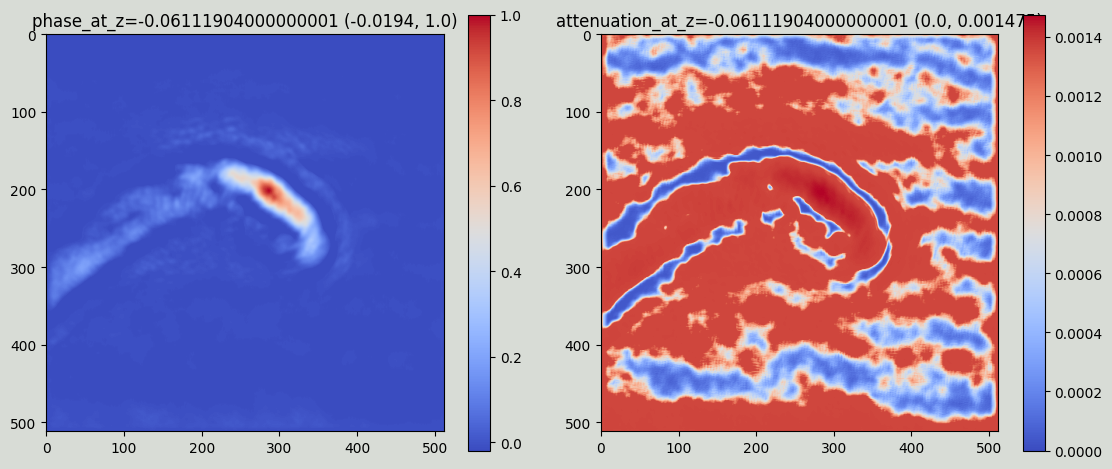

gen_loss:  tensor(5.5250, device='cuda:1', grad_fn=<AddBackward0>) dis_loss:  tensor(1.4047, device='cuda:1', grad_fn=<AddBackward0>) main_diff:  tensor(0.0691, device='cuda:1', grad_fn=<MeanBackward0>) t_epoch:  0.08465909957885742 remaining time:  8 seconds
rows:  1 cols:  2


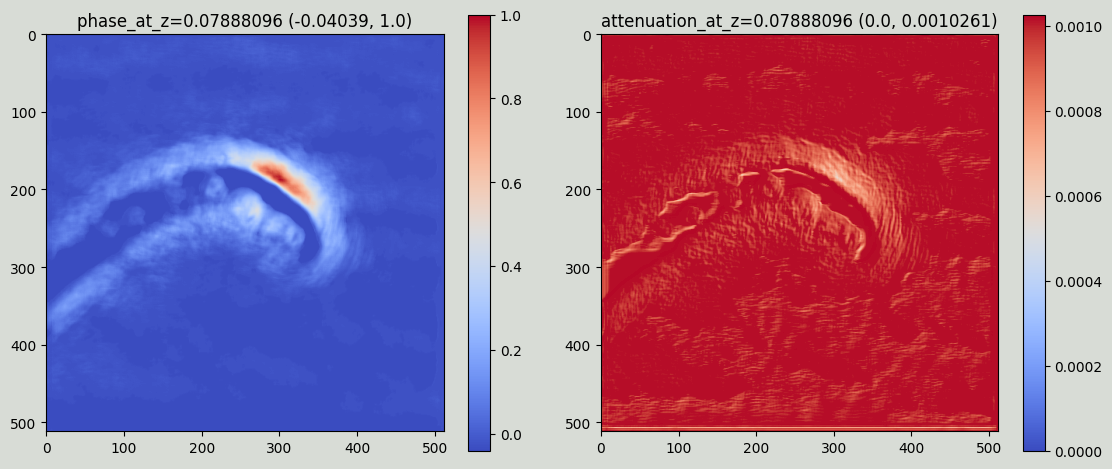

gen_loss:  tensor(4.4508, device='cuda:1', grad_fn=<AddBackward0>) dis_loss:  tensor(1.4244, device='cuda:1', grad_fn=<AddBackward0>) main_diff:  tensor(0.0586, device='cuda:1', grad_fn=<MeanBackward0>) t_epoch:  0.08431839942932129 remaining time:  8 seconds
rows:  1 cols:  2


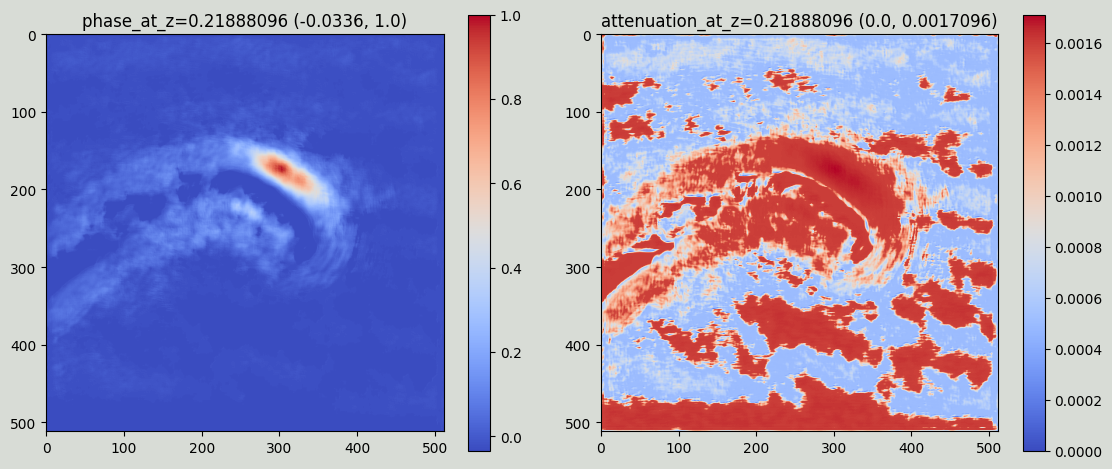

In [100]:
ratio = {'l1_ratio': 10, 'contrast_ratio': 0, 'normalized_ratio': 5, 'brightness_ratio': 0, 'contrast_normalize_ratio': 0, 'brightness_normalize_ratio': 0, 'l2_ratio': 0, 'fourier_ratio': 1}

import pandas as pd
df = pd.DataFrame(columns=['epoch', 'gen_loss', 'dis_loss', 'main_diff'])
df.index.name = 'distance'
for i in range(len(possible_distances)):
    model.distance_sample_detector = possible_distances[i]
    model.fresnel_factor = to_device(possible_fresnels_factors[i], model.device)
    gen_loss_list, dis_loss_list, propagated_intensity_list, phase_list, attenuation_list = model.train(save_model = False, save_model_path = 'model/ganrec_model', **ratio)
    df.loc[i] = [model.epoch, gen_loss_list[-1], dis_loss_list[-1], model.main_diff_list[-1]]
    f = visualize([model.phase_list[-1], model.attenuation_list[-1]], title=['phase_at_z='+str(model.distance_sample_detector), 'attenuation_at_z='+str(model.distance_sample_detector)], show_or_plot='show', cmap='coolwarm')

df.to_csv('comparing.csv')



In [77]:
ratio = {'l1_ratio': 10, 'contrast_ratio': 0, 'normalized_ratio': 5, 'brightness_ratio': 0, 'contrast_normalize_ratio': 0, 'brightness_normalize_ratio': 0, 'l2_ratio': 0, 'fourier_ratio': 1}
model = make_ganrec_model(**dataloader.get_kwargs())

gen_loss_list, dis_loss_list, propagated_intensity_list, phase_list, attenuation_list = model.train(save_model = False, save_model_path = 'model/ganrec_model', **ratio)
# visualize([propagated_intensity_list[-1], model.difference], show_or_plot='show', title = ['propagated_intensity', 'difference'], cmap='Greens_r')


gen_loss:  tensor(6.9484, device='cuda:1', grad_fn=<AddBackward0>) dis_loss:  tensor(1.5113, device='cuda:1', grad_fn=<AddBackward0>) main_diff:  tensor(0.0712, device='cuda:1', grad_fn=<MeanBackward0>) t_epoch:  0.08374571800231934 remaining time:  8 seconds


____________________________________
| brightness_normalize_ratio: 0 
| contrast_normalize_ratio: 0 
| normalized_ratio: 5 
| brightness_ratio: 0 
| contrast_ratio: 0 
| fourier_ratio: 1 
| l1_ratio: 10 
| l2_ratio: 0 
____________________________________ 

rows:  1 cols:  2


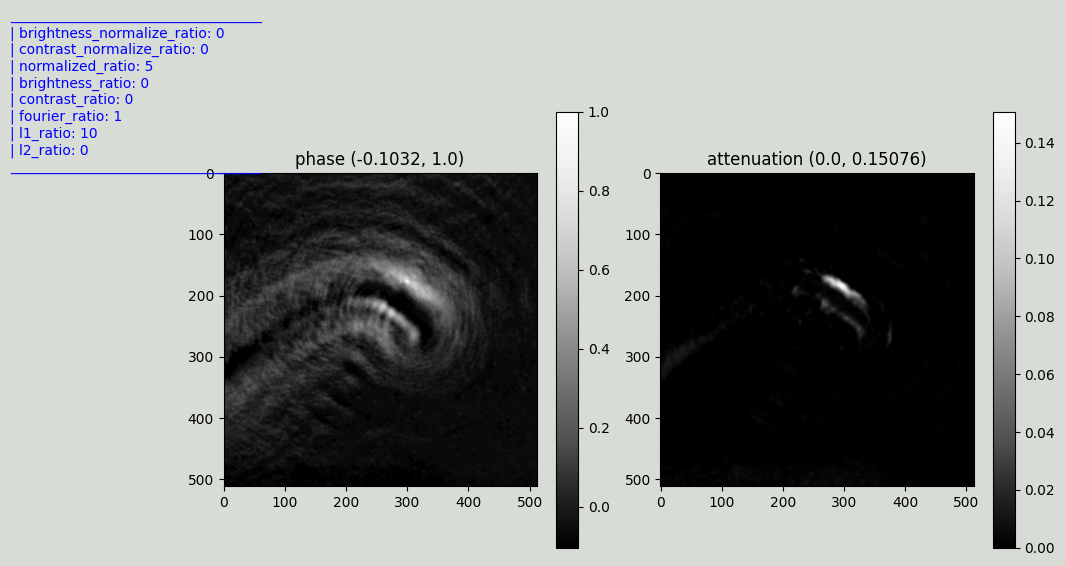

In [67]:
f = visualize([model.phase_list[-1], model.attenuation_list[-1]], title=['phase', 'attenuation', ], cmap='Greys_r', show_or_plot='show', dict=ratio)

____________________________________
| brightness_normalize_ratio: 0 
| contrast_normalize_ratio: 0 
| normalized_ratio: 5 
| brightness_ratio: 0 
| contrast_ratio: 0 
| fourier_ratio: 1 
| l1_ratio: 10 
| l2_ratio: 0 
____________________________________ 

rows:  1 cols:  3


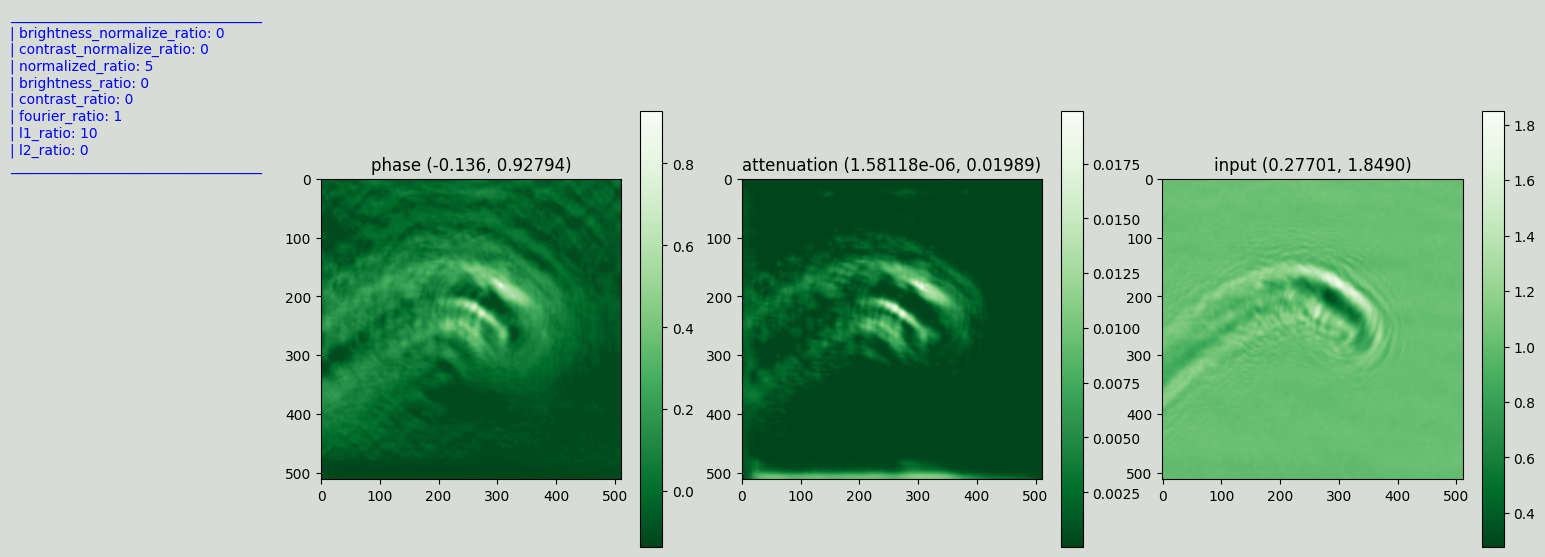

In [64]:
def resize_images_and_view(model, ratio, rotate = True):
    new_shape = model.phase_list[-1][-1].shape
    new_shape = (new_shape[0]*model.downsampling_factor, new_shape[1]*model.downsampling_factor)
    resized_phase = resize(model.phase_list[-1][-1], new_shape, anti_aliasing=True)
    resized_attenuation = resize(model.attenuation_list[-1][-1], new_shape, anti_aliasing=True)
    resized_input = resize(tensor_to_np(model.transformed_images)[0], new_shape, anti_aliasing=True)
    if rotate:
        rotated_phase = np.rot90(resized_phase)
        rotated_attenuation = np.rot90(resized_attenuation)
        rotated_input = np.rot90(resized_input)
        f = visualize([rotated_phase, rotated_attenuation, rotated_input], title=['rotated_phase', 'rotated_attenuation', 'rotated_input'], cmap='Greens_r', show_or_plot='show', dict=ratio)
    else:
        f = visualize([resized_phase, resized_attenuation, resized_input], title=['phase', 'attenuation', 'input'], cmap='Greens_r', show_or_plot='show', dict=ratio)

resize_images_and_view(model, ratio, rotate = False)

rows:  1 cols:  2


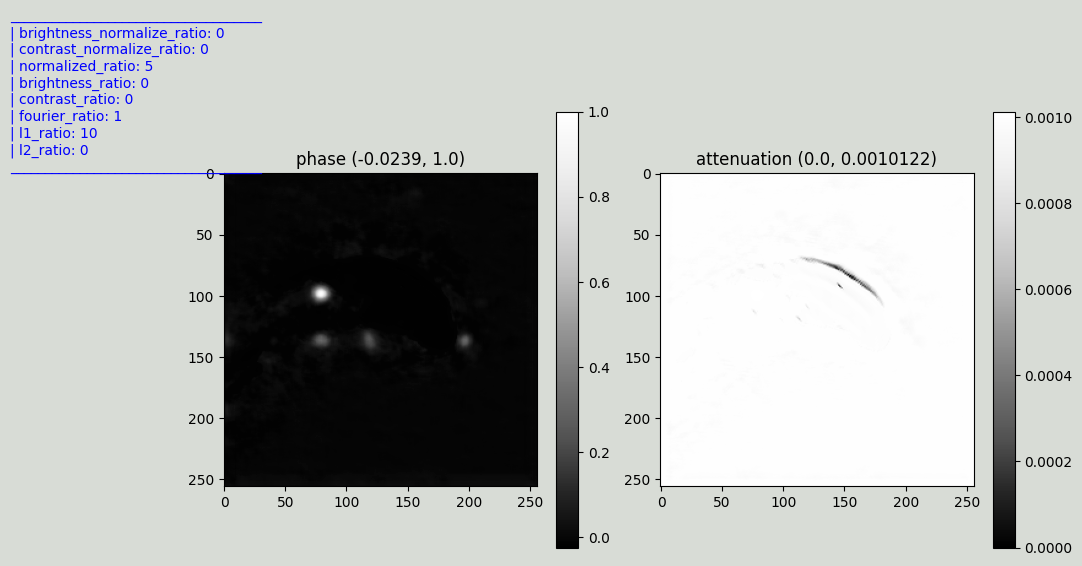

In [18]:
f = visualize([model.phase_list[-1], model.attenuation_list[-1]], title=['phase', 'attenuation', 'input'], cmap='Greys_r', show_or_plot='show', dict=ratio)

rows:  1 cols:  2


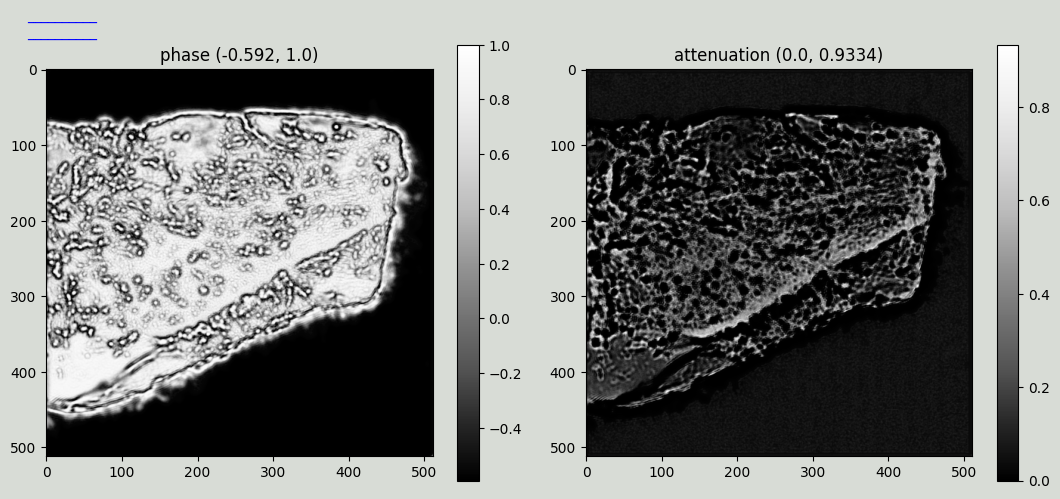

In [ ]:
f = visualize([model.phase_list[-1], model.attenuation_list[-1]], title=['phase', 'attenuation', 'input'], cmap='Greys_r', show_or_plot='show', dict=ratio)

rows:  1 cols:  3


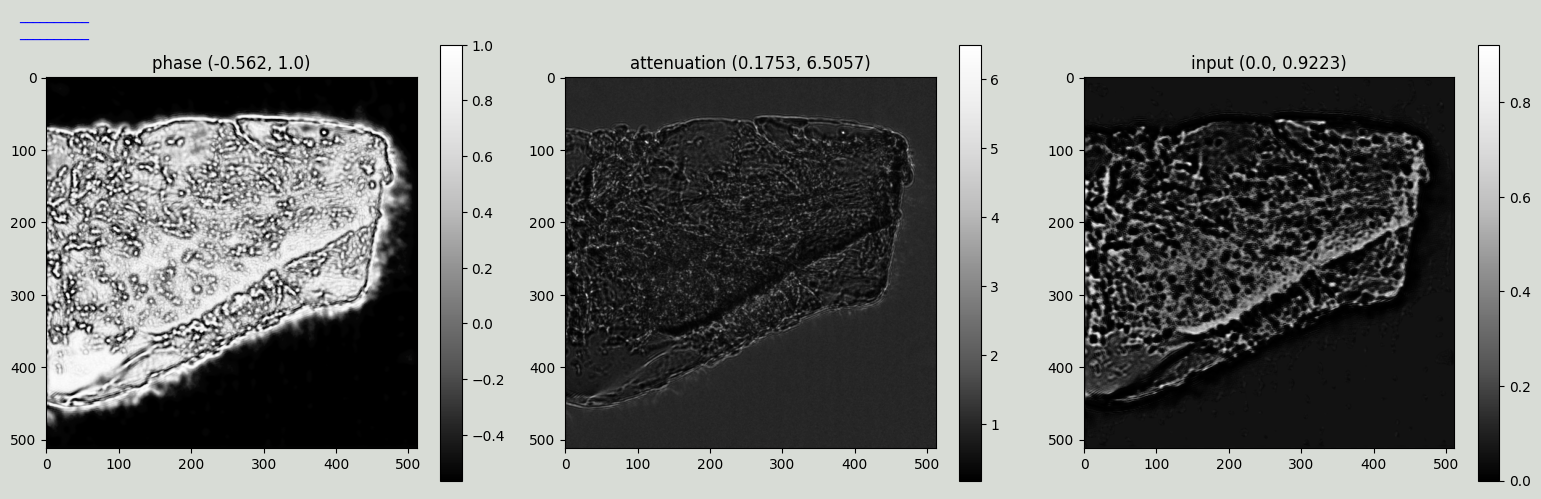

In [ ]:
f = visualize([model.phase_list[-1], model.attenuation_list[-1], model.transformed_images], title=['phase', 'attenuation', 'input'], cmap='Greys_r', show_or_plot='show', dict=ratio)

In [ ]:
#save phase and attenuation
save_path = '/home/hailudaw/hailudaw/git_folders/ganrec/ganrectorch/data/sami/'
kwargs = model.__dict__
name_file ='reshape_only_no_contrast'+ kwargs['transform_type']+'_ratio_'+str(kwargs['transform_factor'])+'_iter_'+str(kwargs['iter_num'])+'_abs_ratio_'+str(kwargs['abs_ratio'])+'_pad_'+str(kwargs['pad'])+'_energy_'+str(kwargs['energy_kev'])+'_pv_'+str(kwargs['pv'])+'_z_'+str(kwargs['z'])+'_fresnel_'+str(kwargs['fresnel_number'])+'_lam_'+str(kwargs['lam'])+'_mode_'+str(kwargs['mode'])+'_value_'+str(kwargs['value'])+'_idx_'+'.tiff'
io.imsave(save_path + 'phase/'+name_file, model.phase_list[-1][-1])
io.imsave(save_path + 'abs/'+name_file, model.attenuation_list[-1][-1])
io.imsave(save_path + 'propagated/'+name_file, propagated_intensity_list[-1][-1])
io.imsave(save_path + name_file, tensor_to_np(model.transformed_images)[-1])

In [ ]:
# model.live_plot(rate=model.iter_num//10)

In [ ]:
from scipy.ndimage import gaussian_filter, median_filter

def gaussian(image, sigma = 1):
    return gaussian_filter(image, sigma = sigma)

def median(image, size = 3):
    return median_filter(image, size = size)

median_image = median(dataloader.image, size = 40)
gaussian_image = gaussian(dataloader.image, sigma = 1)
visualize([median_image, gaussian_image])

In [ ]:
def tfback_phase(img, input):
    img_final = tf.numpy_function(match_histograms, [img, input], tf.float32)
    return tf_reshape(img_final)

from skimage.exposure import match_histograms
def torchback_phase(img, input):
    img_final = torch_reshape(match_histograms(tensor_to_np(img), input), complex=True)
    return img_final

torchback_phase(dataloader.image, dataloader.transformed_images)